In [106]:
#Import libraries:
%reload_ext autoreload
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, IsolationForest
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

from sklearn.ensemble import AdaBoostClassifier  

from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.metrics import roc_curve, auc, confusion_matrix, recall_score

# !pip install imblearn
from imblearn.over_sampling import SMOTE

%autoreload 2
import src.scripts as src

df = src.read_from_efs('df_npi.csv').reset_index()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [97]:
df.head()

,npi,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,cost_per_bene,cost_per_claim,label
0,1003000126,984.0,1357,1417.2,31568,48902.50,49.697663,36.037214,False
1,1003000142,1143.0,4522,4688.1,134063,301708.47,263.961916,66.720139,False
2,1003000167,70.0,152,154.1,1343,694.58,9.922571,4.569605,False
3,1003000282,42.0,55,59.0,1481,736.02,17.524286,13.382182,False
4,1003000407,1245.0,3042,3054.9,59672,124382.85,99.905904,40.888511,False


In [98]:
target = 'label'
IDcol = 'npi'

In [103]:
class Model:
    def __init__(self):
        self.y_pred = None
        self.y_prob = None
        self.alg = None

    def modelfit(self, alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
        #Fit the algorithm on the data
        alg.fit(dtrain[predictors], dtrain[target])
        self.alg = alg
        
        #Predict training set:
        dtrain_predictions = alg.predict(dtrain[predictors])
        self.y_pred = dtrain_predictions
        dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        self.y_prob = dtrain_predprob

        #Perform cross-validation:
        if performCV:
            cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=cv_folds, scoring='roc_auc')

        #Print model report:
        print("\nModel Report")
        print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
        print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))

        if performCV:
            print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))

        #Print Feature Importance:
        if printFeatureImportance:
            feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
            feat_imp.plot(kind='bar', title='Feature Importances')
            plt.ylabel('Feature Importance Score')

In [100]:
print('Label Distributions: ')
df['label'].value_counts()

Label Distributions: 


False    1042071
True        1125
Name: label, dtype: int64

In [107]:
#Train test split
train, test = train_test_split(df, test_size=.2, stratify=df[target])

#Apply SMOTE sampling after train test split
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(train[predictors], train[target])
train_smote = pd.DataFrame(data = x_train_res, columns=predictors)
train_smote['label'] = y_train_res
print('Label Distributions (SMOTE): ')
train_smote['label'].value_counts()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Label Distributions (SMOTE): 


True     833656
False    833656
Name: label, dtype: int64


Model Report
Accuracy : 0.999
AUC Score (Train): 0.780082
CV Score : Mean - 0.6277506 | Std - 0.02920843 | Min - 0.605305 | Max - 0.6854845
Duration in seconds:  415.8624472618103


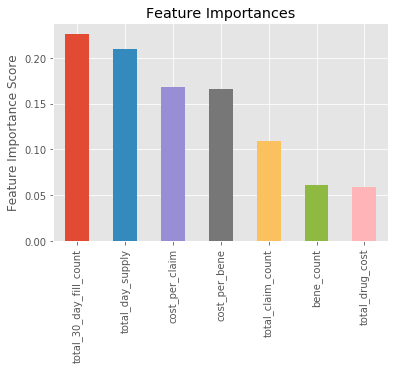

In [122]:
#Choose all predictors except target & IDcols
s_time = time.time()
model = Model()
predictors = [x for x in train_smote.columns if x not in [target, IDcol]]
cf = GradientBoostingClassifier(random_state=10) # Classifier algo
# cf = RandomForestClassifier(random_state=10) # Classifier algo
model.modelfit(cf, train, predictors)
e_time = time.time()
print('Duration in seconds: ', e_time - s_time)

In [126]:
test[target].value_counts()

False    208415
True        225
Name: label, dtype: int64

In [127]:
# confusion matrix
y_test = test[target]
y_pred = model.alg.predict(test[predictors])
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tp, fp)
print(tn, fn)
print(fn/(fn+tp))

0 55
208360 225
1.0


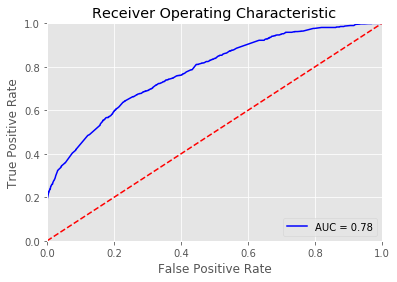

In [128]:
# ROC Curve
y_prob = model.y_prob
y_test = train[target]

fpr, tpr, threshold = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

1125

In [ ]:
processors = 64
print("Number of available CPU cores: ")
!cat /proc/cpuinfo | grep processor | wc -l

In [ ]:
s_time = time.time()

#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]

#Gridsearch for optimal number of estimators
param_test1 = {'n_estimators': list(range(20,101,10))}

gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.5, 
                                                               min_samples_split=500,
                                                               min_samples_leaf=50,
                                                               max_depth=8,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=10),
                        param_grid = param_test1, 
                        scoring='roc_auc', 
                        n_jobs=processors,
                        iid=False, 
                        cv=5)

gsearch1.fit(train[predictors],train[target])
e_time = time.time()
print('Duration in seconds: ', e_time - s_time)
gsearch1.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [65]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.65404, std: 0.01445, params: {'n_estimators': 20},
  mean: 0.65490, std: 0.01606, params: {'n_estimators': 30},
  mean: 0.65494, std: 0.01718, params: {'n_estimators': 40},
  mean: 0.65512, std: 0.01731, params: {'n_estimators': 50},
  mean: 0.65660, std: 0.01702, params: {'n_estimators': 60},
  mean: 0.65575, std: 0.01557, params: {'n_estimators': 70},
  mean: 0.65712, std: 0.01713, params: {'n_estimators': 80}],
 {'n_estimators': 80},
 0.657116199111557)

In [44]:

param_test2 = {'max_depth':range(5,16,2), 
               'min_samples_split':list(range(200,1001,200))}

gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               n_estimators=60, 
                                                               max_features='sqrt', 
                                                               subsample=0.8, 
                                                               random_state=10), 
                        param_grid = param_test2, 
                        scoring='roc_auc',
                        n_jobs=processors,
                        iid=False, 
                        cv=5)

gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

""


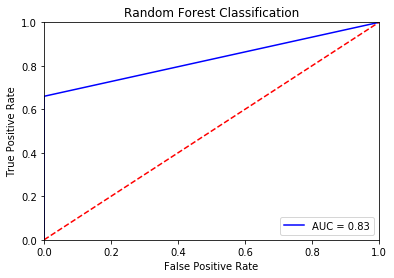

In [16]:
param_test3 = {'min_samples_split':range(1000,2100,200), 
               'min_samples_leaf':range(30,71,10)}

gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               n_estimators=60,
                                                               max_depth=9,
                                                               max_features='sqrt', 
                                                               subsample=0.8, 
                                                               random_state=10),
                        param_grid = param_test3, 
                        scoring='roc_auc',
                        n_jobs=processors,
                        iid=False, 
                        cv=5)

gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_


In [17]:
modelfit(gsearch3.best_estimator_, train, predictors)

Actual,False,True
Predicted,,
False,39333,400
True,53,0


In [ ]:
param_test4 = {'max_features':range(7,20,2)}

gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               n_estimators=60,
                                                               max_depth=9, 
                                                               min_samples_split=1200, 
                                                               min_samples_leaf=60, 
                                                               subsample=0.8, 
                                                               random_state=10),
                        param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_